

```
To view the Map Alone: Scroll to the [bottom](https://colab.research.google.com/drive/11KM6PgMLILYalCn-OEAM3sfRxrRkM2_B#scrollTo=JbiIDMW-dZYt&line=1&uniqifier=1). Or continue below to review the process, of compiling SQL database, analysis and creation of the map.


In [ ]:
import pandas as pd
import sqlite3
import os
import requests

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
# We define our sources in a dictionary so we can loop through them
data_sources = {
    2024: "https://open.canada.ca/data/dataset/7e0189e3-8595-4e62-a4e9-4fed6f265e10/resource/bfbc387f-ac55-4bf6-8656-5a14078386be/download/nspl2024_opengov_list_jun12.xlsx",
    2023: "https://open.canada.ca/data/dataset/7e0189e3-8595-4e62-a4e9-4fed6f265e10/resource/80cd9c3c-2fc9-4a4c-bd3d-e71bbd4d79ce/download/hpd-nspl_2023_opengov_bil-20240815-final.xlsx",
    2022: "https://open.canada.ca/data/dataset/7e0189e3-8595-4e62-a4e9-4fed6f265e10/resource/5e3c9df6-ffbd-49a8-a7a7-de9629c2f458/download/hpd-nspl_2022_opengov_bil-20231121-final.xlsx",
    2021: "https://open.canada.ca/data/dataset/7e0189e3-8595-4e62-a4e9-4fed6f265e10/resource/dd8d935c-3e40-42d1-8de3-2e18f3877000/download/hpd-nspl_2021_opengov-final.xlsx",
    2020: "https://open.canada.ca/data/dataset/7e0189e3-8595-4e62-a4e9-4fed6f265e10/resource/4af81051-d598-467a-b29d-ed3e3f73a741/download/national-service-provider-list-national-service-provider-list-_-la-liste-nationale-des-fournisse.xls",
    2019: "https://open.canada.ca/data/dataset/7e0189e3-8595-4e62-a4e9-4fed6f265e10/resource/034882c4-60e0-4259-8a13-bcf9c0a93391/download/final_chpdopendatanspl_dataset-2019_june7_2020.csv"
}

# The standardized columns we want in our final database
target_columns = ['Year', 'Shelter_Name', 'City', 'Province', 'Capacity', 'Organization_Name']

# Helper to normalize column names (Government files are messy!)
def clean_col_name(col):
    col = str(col).strip().lower()
    col = col.replace('/', '_').replace(' ', '_').replace('-', '_')
    # Map variations to a standard name
    if 'province' in col or 'territory' in col: return 'Province'
    if 'city' in col or 'ville' in col: return 'City'
    if 'capacity' in col or 'bed' in col or 'capacité' in col: return 'Capacity'
    if 'shelter' in col and 'name' in col: return 'Shelter_Name'
    if 'org' in col and 'name' in col: return 'Organization_Name'
    return col

all_data = []

# ==========================================
# 2. EXTRACT & TRANSFORM (LOOP THROUGH YEARS)
# ==========================================
print("Starting ETL Process...")

for year, url in data_sources.items():
    filename = f"nspl_{year}"

    try:
        # A. DOWNLOAD
        print(f"[{year}] Downloading...", end=" ")
        # We use pandas directly to read from URL when possible, but 'xls' needs special care
        if url.endswith('.csv'):
            df = pd.read_csv(url, encoding='latin1') # 'latin1' often fixes gov CSVs
        elif url.endswith('.xls'):
            df = pd.read_excel(url, engine='xlrd')   # 'xlrd' is needed for old Excel 97-2003 format
        else:
            df = pd.read_excel(url)                  # Standard xlsx

        print(f"Loaded {len(df)} rows.", end=" ")

        # B. CLEAN COLUMNS
        # Ensure unique column names after cleaning to prevent InvalidIndexError during concat.
        final_cols_for_this_df = []
        actual_cols_to_keep_from_original_df = []
        seen_names = set()

        for original_col in df.columns:
            cleaned_name = clean_col_name(original_col)
            if cleaned_name not in seen_names:
                final_cols_for_this_df.append(cleaned_name)
                actual_cols_to_keep_from_original_df.append(original_col)
                seen_names.add(cleaned_name)

        df = df[actual_cols_to_keep_from_original_df] # Select only the columns that will have unique cleaned names
        df.columns = final_cols_for_this_df # Assign the unique cleaned names

        # C. STANDARDIZE DATA
        df['Year'] = year

        # Ensure Capacity is numeric (force non-numbers to 0)
        if 'Capacity' in df.columns:
            df['Capacity'] = pd.to_numeric(df['Capacity'], errors='coerce').fillna(0)
        else:
            df['Capacity'] = 0 # Fallback if column missing

        # Ensure Province is clean (e.g. "ON" vs "Ontario")
        # You can add more mapping logic here if needed

        # D. FILTER & SELECT
        # Keep only the columns we care about, if they exist
        existing_cols = [c for c in target_columns if c in df.columns]
        df_clean = df[existing_cols].copy()

        all_data.append(df_clean)
        print("✓ Cleaned.")

    except Exception as e:
        print(f"\n❌ Error processing {year}: {e}")

# ==========================================
# 3. MERGE & LOAD TO SQL
# ==========================================
print("\nMerging datasets...")
if all_data:
    # Stack all years
    master_df = pd.concat(all_data, ignore_index=True)

    # Connect to SQLite database (creates it if it doesn't exist)
    conn = sqlite3.connect('housing_database.db')

    # Write to SQL
    master_df.to_sql('shelters', conn, if_exists='replace', index=False)

    print(f"SUCCESS! Database created: 'housing_database.db'")
    print(f"Total Records: {len(master_df)}")

    # ==========================================
    # 4. VERIFY WITH A TEST QUERY
    # ==========================================
    print("\n--- Verifying Data by Year ---")
    query = "SELECT Year, COUNT(*) as Count, SUM(Capacity) as Total_Beds FROM shelters GROUP BY Year ORDER BY Year DESC"
    verification = pd.read_sql(query, conn)
    display(verification)

    conn.close()
else:
    print("No data was loaded.")

Starting ETL Process...
[2024] Downloading... Loaded 1114 rows. ✓ Cleaned.
[2023] Downloading... Loaded 1117 rows. ✓ Cleaned.
[2022] Downloading... Loaded 1120 rows. ✓ Cleaned.
[2021] Downloading... Loaded 889 rows. ✓ Cleaned.
[2020] Downloading... Loaded 787 rows. ✓ Cleaned.
[2019] Downloading... Loaded 816 rows. ✓ Cleaned.

Merging datasets...
SUCCESS! Database created: 'housing_database.db'
Total Records: 5843

--- Verifying Data by Year ---


,Year,Count,Total_Beds
0,2024,1114,33682.0
1,2023,1117,32273.0
2,2022,1120,30402.0
3,2021,889,23335.0
4,2020,787,23762.0
5,2019,816,23965.0


In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('housing_database.db')

query = """
SELECT
    Year,
    City,
    SUM(Capacity) as Total_Beds
FROM
    shelters
WHERE
    (Province LIKE 'ON%' OR Province LIKE 'Ontario%')
    AND City IN ('Toronto', 'Ottawa', 'Hamilton', 'London')
GROUP BY
    City, Year
ORDER BY
    City, Year
"""

df_trends = pd.read_sql(query, conn)
display(df_trends.pivot(index='City', columns='Year', values='Total_Beds'))

Year,2019,2020,2021,2022,2023,2024
City,,,,,,
Hamilton,513.0,451.0,670.0,753.0,695.0,621.0
London,479.0,452.0,470.0,480.0,489.0,497.0
Ottawa,939.0,880.0,994.0,1254.0,1539.0,1936.0
Toronto,4116.0,4340.0,3856.0,3838.0,4158.0,4186.0


Analyzing trends for: Toronto, Ottawa, Hamilton, London, Mississauga, Kitchener, St. Catharines, Windsor, Barrie, Brampton


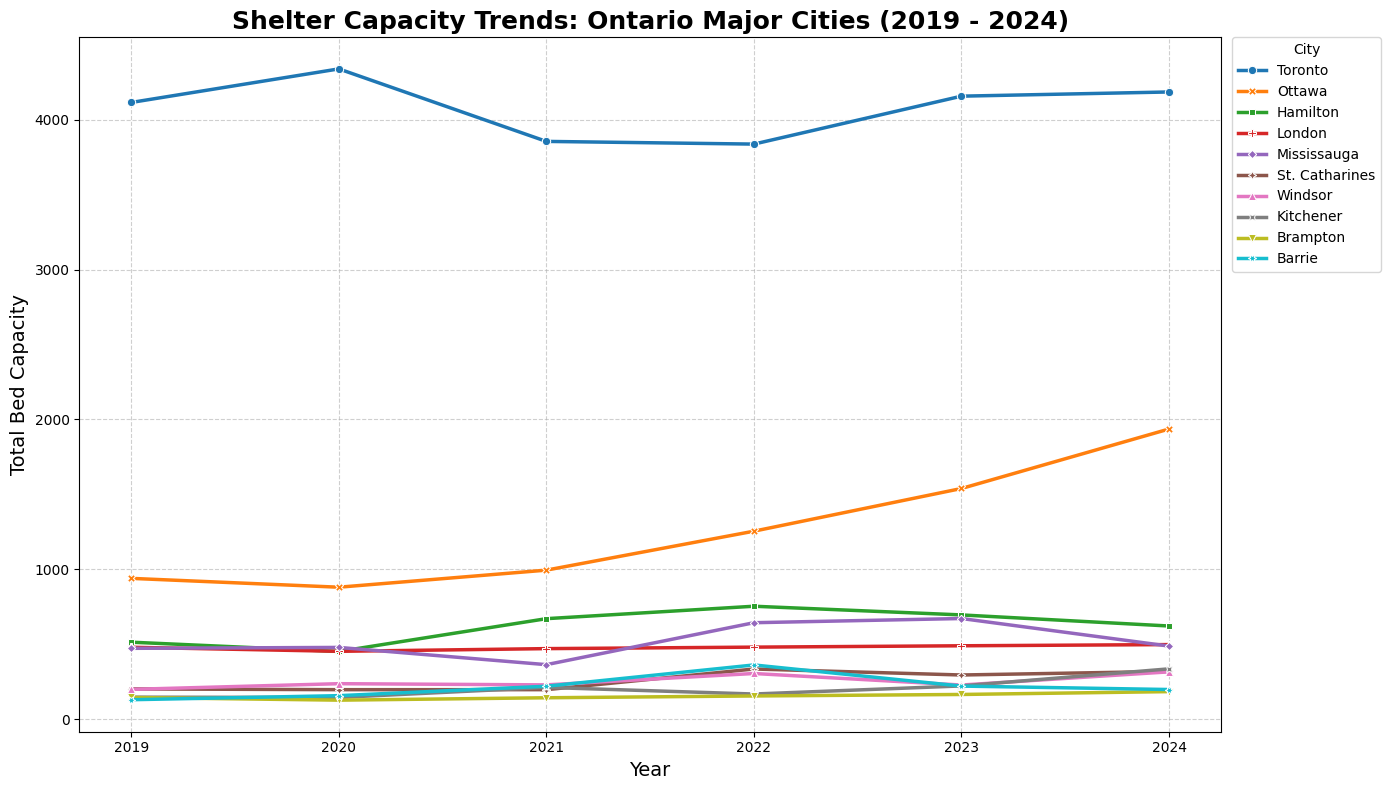


Detailed Capacity Numbers:


Year,2019,2020,2021,2022,2023,2024,5_Year_Growth
City,,,,,,,
Barrie,129,156,219,361,220,197,68
Brampton,144,126,142,154,164,183,39
Hamilton,513,451,670,753,695,621,108
Kitchener,146,144,211,167,221,335,189
London,479,452,470,480,489,497,18
Mississauga,472,478,363,643,671,487,15
Ottawa,939,880,994,1254,1539,1936,997
St. Catharines,201,196,196,334,294,318,117
Toronto,4116,4340,3856,3838,4158,4186,70


In [ ]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ==========================================
# 1. CONNECT & PREPARE DATA
# ==========================================
conn = sqlite3.connect('housing_database.db')

# Step A: Identify the Top 10 Cities in Ontario (based on latest 2024 data)
# This ensures we only plot the relevant major cities
top_cities_query = """
SELECT City
FROM shelters
WHERE Year = 2024
  AND (Province LIKE 'ON%' OR Province LIKE 'Ontario%')
GROUP BY City
ORDER BY SUM(Capacity) DESC
LIMIT 10
"""
top_cities_df = pd.read_sql(top_cities_query, conn)
top_cities_list = top_cities_df['City'].tolist()

print(f"Analyzing trends for: {', '.join(top_cities_list)}")

# Step B: Extract history ONLY for those top cities
# We use a dynamic SQL query to filter for these specific names
placeholders = ','.join(['?'] * len(top_cities_list))
query_trends = f"""
SELECT
    Year,
    City,
    SUM(Capacity) as Total_Beds
FROM
    shelters
WHERE
    City IN ({placeholders})
    AND (Province LIKE 'ON%' OR Province LIKE 'Ontario%')
GROUP BY
    City, Year
ORDER BY
    Year ASC, Total_Beds DESC
"""

# Load data
df_trends = pd.read_sql(query_trends, conn, params=top_cities_list)

# ==========================================
# 2. GENERATE TIME SERIES CHART
# ==========================================
plt.figure(figsize=(14, 8))

# Create Line Plot
chart = sns.lineplot(
    data=df_trends,
    x='Year',
    y='Total_Beds',
    hue='City',          # Different color for each city
    style='City',        # Different line styles (solid, dashed) helps readability
    markers=True,
    dashes=False,
    linewidth=2.5,
    palette='tab10'      # High contrast color palette
)

# Formatting
plt.title('Shelter Capacity Trends: Ontario Major Cities (2019 - 2024)', fontsize=18, fontweight='bold')
plt.ylabel('Total Bed Capacity', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid(True, which='major', linestyle='--', alpha=0.6)

# Force X-axis to show only whole integer years (2019, 2020...)
chart.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Move legend outside the plot so it doesn't cover data
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title='City')

plt.tight_layout()
plt.show()

# ==========================================
# 3. SHOW DATA TABLE (PIVOT VIEW)
# ==========================================
# This rearranges the data so Years are columns (easier to read)
pivot_table = df_trends.pivot(index='City', columns='Year', values='Total_Beds')

# Optional: Add a "Growth" column to see the % change from 2019 to 2024
if 2019 in pivot_table.columns and 2024 in pivot_table.columns:
    pivot_table['5_Year_Growth'] = pivot_table[2024] - pivot_table[2019]

print("\nDetailed Capacity Numbers:")
display(pivot_table.fillna(0).astype(int).style.background_gradient(cmap='Reds'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [12]:
import sqlite3
import pandas as pd
import folium
from folium.plugins import TimestampedGeoJson
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# ==========================================
# 1. PREPARE THE DATA
# ==========================================
conn = sqlite3.connect('housing_database.db')

query = """
SELECT Year, City, SUM(Capacity) as Total_Beds
FROM shelters
WHERE (Province LIKE 'ON%' OR Province LIKE 'Ontario%')
GROUP BY City, Year
ORDER BY Year ASC
"""
df_all = pd.read_sql(query, conn)

# ==========================================
# 2. GEOCODE (Cached)
# ==========================================
if 'city_coords' not in locals():
    unique_cities = df_all['City'].unique()
    geolocator = Nominatim(user_agent="ontario_housing_portfolio_final_v4")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    city_coords = {}

    print(f"Geocoding {len(unique_cities)} cities...")
    for city in unique_cities:
        try:
            loc = geolocator.geocode(f"{city}, Ontario, Canada")
            if loc is None:
                loc = geolocator.geocode(f"{city} City Hall, Ontario, Canada")
            if loc:
                city_coords[city] = [loc.latitude, loc.longitude]
        except:
            continue
    print("✓ Geocoding complete.")

# ==========================================
# 3. CREATE ANIMATED FEATURES
# ==========================================
features = []

for idx, row in df_all.iterrows():
    city = row['City']
    year = row['Year']
    beds = row['Total_Beds']

    if city not in city_coords:
        continue

    coords = city_coords[city]

    # --- UPDATED 3-TIER LOGIC ---
    if beds > 1000:
        # TIER 1: HIGH CAPACITY (Major Hubs)
        color_choice = 'crimson'
        radius_size = beds / 300

    elif beds < 100:
        # TIER 3: LOW CAPACITY (Small Towns)
        # We use a FIXED size so they don't disappear
        color_choice = '#20b2aa' # Light Sea Green (Teal)
        radius_size = 5          # Fixed visible dot

    else:
        # TIER 2: MEDIUM CAPACITY (Regional Centers)
        color_choice = 'gold'
        radius_size = beds / 50

    # Create Feature
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [coords[1], coords[0]],
        },
        'properties': {
            'time': f'{year}-01-01T12:00:00',

            # Label
            'tooltip': f"{city}: {int(beds)} Beds",
            'popup': f"<b>{city} ({year})</b><br>Capacity: {int(beds)} Beds",

            # Style
            'icon': 'circle',
            'iconstyle': {
                'fillColor': color_choice,
                'fillOpacity': 0.8,
                'stroke': 'false',
                'radius': radius_size
            }
        }
    }
    features.append(feature)

# ==========================================
# 4. RENDER MAP
# ==========================================
m = folium.Map(
    location=[45.5, -80.0],
    zoom_start=6,
    min_zoom=5,
    max_bounds=True,
    min_lat=41.0, max_lat=57.0,
    min_lon=-96.0, max_lon=-74.0
)

# Add Legend (Optional but professional for 3 categories)
legend_html = '''
     <div style="position: fixed;
     bottom: 50px; left: 50px; width: 160px; height: 100px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity:0.85; padding: 10px;">
     <b>Capacity Legend</b><br>
     <i style="background:crimson; width:10px; height:10px; display:inline-block; border-radius:50%;"></i> > 1000 Beds<br>
     <i style="background:gold; width:10px; height:10px; display:inline-block; border-radius:50%;"></i> 100 - 1000 Beds<br>
     <i style="background:#20b2aa; width:10px; height:10px; display:inline-block; border-radius:50%;"></i> < 100 Beds
     </div>
     '''
m.get_root().html.add_child(folium.Element(legend_html))

TimestampedGeoJson(
    {'type': 'FeatureCollection', 'features': features},
    period='P1Y',
    duration='P1Y',
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY',
    time_slider_drag_update=True
).add_to(m)

print("Interactive Map Ready: 3 Categories (Red, Gold, Teal)")
display(m)

Interactive Map Ready: 3 Categories (Red, Gold, Teal)


In [13]:
# ==========================================
# 5. SAVE AS STANDALONE HTML
# ==========================================

# Define the output filename
output_file = 'ontario_shelter_map.html'

# Save the map to an HTML file
m.save(output_file)

print(f"SUCCESS: Map saved as '{output_file}'")

# If you are in Google Colab, run this to download it automatically:
try:
    from google.colab import files
    files.download(output_file)
except ImportError:
    print("File saved locally. Look in your folder for 'ontario_shelter_map.html'")

SUCCESS: Map saved as 'ontario_shelter_map.html'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>